# [T273116](https://phabricator.wikimedia.org/T273116) Data QA for Create Oozie job for session length


In this task we will be verifying if events in mforns.session_length_daily (__intermediate table__) is sessionized correctly from the source schema (__raw table__) [event.mediawiki_client_session_tick](https://gerrit.wikimedia.org/r/plugins/gitiles/schemas/event/secondary/+/refs/heads/master/jsonschema/analytics/session_tick/2.0.0.yaml) and if the Instrumentation 
is working correctly.  

Currently the instrumentation is deployed on [Group 0 and Group 1](https://wikitech.wikimedia.org/wiki/Deployments/Train) wikis only.

**Observations from Session Length data-QA of intermediate table** 
1. Compared with data from mediawiki_client_session_tick for a few days (Jan 5 to Jan 21, 2021)  
- The total session length duration in the sessionized table is more than the raw table by 0.19%   
This could be because sessions are capped at the day level in the sessionized table. If there are sessions that extend beyond 00:00 UTC in the raw table they will be missing tick 0s (start of the session) in the intermediate table.
Hence we’re adding 1 minute for each missing tick, that results from cutting a session at start/end of day.  
To learn more about this, please refer to [Session Length - Interrupted Sessions](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Traffic/SessionLength#Interrupted_sessions)  
- The number of sessions in the raw table and sessionized table is different. 
2. Min and Max values of the session length between the two tables checks out  
3. The ‘wiki’ field in the intermediate table consists of both desktop web and mobile web events of a wiki ie we will be able to tell them apart only in the raw table.    
4. The intermediate table will have sessions only from the wmf domain. It will also filter out events from translate.google  

5. We compared the differences between the number of sessions of a certain session length in the raw and intermediate table on multiple levels - per day, per wiki, and overall. Positive offset values indicated that the number of sessions in the intermediate table is greater than raw table and negative offset indicated vice versa. We then built a histogram of the values to illustrate the differences and then calculated percentiles of sessions to compare the values between the two tables.  
 a) On a per day or per wiki basis, the data shows that most session lengths have an equal number of sessions between the two tables i.e. difference of 0.   
 b) On a per day or per wiki basis, the session lengths that are different have a small variation in the number of sessions between the two tables.  
 c) However, when we compared All of the data in the two tables, we saw that very few session lengths had the same number of sessions in the two tables ie majority of the session length differences were non-zero, which was concerning. But then when we calculated the percentile values they were very close or almost the same between the two tables. _Thus the impact of the difference in number of sessions and session length durations in the two tables to percentile values of the session lengths is negligible._



In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter as mpl
import numpy as np
import pandas as pd
from tabulate import tabulate
from wmfdata import charting, hive, mariadb
from wmfdata.charting import comma_fmt, pct_fmt
from wmfdata.utils import df_to_remarkup, pct_str

You are using wmfdata v1.0.1, but v1.0.4 is available.

To update, run `pip install --upgrade git+https://github.com/neilpquinn/wmfdata/wmfdata.git@release`.

To see the changes, refer to https://github.com/neilpquinn/wmfdata/blob/release/CHANGELOG.md


## 1. Session Length duration 
Compare the sessions lengths between the raw table and intermediate table.   
We will do this by calculating the Sum of session lengths from Intermediate table and Count of non-zero Ticks from event table (since one tick is sent every 1 minute) 

In [2]:
# Session Length per day from Intermediate table

sl_day = hive.run("""
SELECT
  date_format(CONCAT(year, '-', month, '-', day),"yyyy-MM-dd"),
  sum(session_length) AS sl_session_length  

FROM mforns.session_length_daily
WHERE
  year = 2021 AND month=1 AND day>=6 
GROUP BY CONCAT(year, '-', month, '-', day)
""")

In [3]:
sl_day['sl_session_length'] = sl_day.apply(lambda x: "{:,}".
                                              format(x['sl_session_length']), axis=1)

In [4]:
sl_day=sl_day.rename(columns={"_c0": "date"})
sl_day.sort_values(by=['date'], inplace=True, ascending=True)
few_sl_day= sl_day[sl_day["date"].isin(['2021-01-06','2021-01-20',
                                        '2021-01-10','2021-01-14'])]

Compare with data from mediawiki_client_session_tick for a few days

In [5]:
# Session Length per day from raw table

sl_day_mwsessiontick = hive.run("""
SELECT
  date_format(meta.dt, "yyyy-MM-dd"),
  COUNT(1) AS mwst_sessionlength
  
FROM event.mediawiki_client_session_tick
WHERE
  year = 2021 
  AND month=1 
  AND day>=6 AND day<22 
  --Since Sessionized table has data from Jan 6 to Jan 21, 2021
  
  AND tick <>0 
  --removing tick 0s since we are counting rows of all the ticks received
  
  AND is_wmf_domain
  --adding filter for removing non-wmf events
  
GROUP BY date_format(meta.dt, "yyyy-MM-dd")
""")

In [6]:
sl_day_mwsessiontick['mwst_sessionlength'] = sl_day_mwsessiontick.apply(
    lambda x: "{:,}".format(x['mwst_sessionlength']),axis=1)                         

In [7]:
sl_day_mwsessiontick=sl_day_mwsessiontick.rename(columns={"_c0": "date"})
sl_day_mwsessiontick.sort_values(by=['date'], inplace=True, ascending=True)
few_mwst= sl_day_mwsessiontick[sl_day_mwsessiontick["date"].isin(['2021-01-06','2021-01-20',
                                        '2021-01-10','2021-01-14'])]

In [8]:
few_mwst

,date,mwst_sessionlength
12,2021-01-06,"22,518,155"
0,2021-01-10,"23,308,255"
4,2021-01-14,"26,669,140"
10,2021-01-20,"28,338,137"


In [9]:
few_sl_day

,date,sl_session_length
12,2021-01-06,"22,546,179"
0,2021-01-10,"23,342,409"
4,2021-01-14,"26,716,655"
10,2021-01-20,"28,402,619"


As you can see, the session lengths per day between the two tables is vastly different (by ~20,000 to 100,000 minutes). 
The Intermediate table has longer session lengths than the raw table. Let's investigate further by looking at the Total session lengths in both tables.

In [10]:
# Total Session Length from event table

total_mwst = hive.run("""
SELECT
  substr(meta.dt, 0, 4) AS year,
  COUNT(1) AS mwst_total_sl
  
FROM event.mediawiki_client_session_tick
WHERE
  year = 2021 
  AND month=1 AND day>=6 AND day < 22
  AND tick <>0
  AND is_wmf_domain
GROUP BY substr(meta.dt, 0, 4)
""")
total_mwst

,year,mwst_total_sl
0,2021,402612299


In [11]:
# Session Length from Aggregated table

total_sl = hive.run("""
SELECT
  year,
  sum(session_length) AS total_sl
FROM mforns.session_length_daily
WHERE
  year = 2021 
  AND month=1 AND day>=6
GROUP BY year
""")
total_sl

,year,total_sl
0,2021,403382822


In [12]:
total_diff=((total_sl['total_sl']-total_mwst['mwst_total_sl'])/total_sl['total_sl'])*100

Percentage difference of the session lengths in both the tables

In [13]:
total_diff

0    0.191015
dtype: float64

When comparing the data, sessionized table has **0.19%** more session length overall than the raw table. 
This is because sessions are capped at the day level in the sessionized table. If there are sessions that extend beyond 00:00 UTC in the raw table they will be missing tick 0s (start of the session) and hence we’re adding 1 minute for each missing tick, that results from cutting a session at start/end of day.  
To learn more about this, please refer to [Session Length - Interrupted Sessions](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Traffic/SessionLength#Interrupted_sessions)

## 2. Number of sessions 
Tick 0 is sent at the start of a session. We will be able to get the total number of sessions by counting the number of tick 0s received in the raw table. 
We will use this count of tick 0s to check if it is equal to the number of sessions (rows of data) recorded in the sessionized table 

In [14]:
# Count Session Length records from Aggregated table

sl_count = hive.run("""
SELECT
  year,
  count(1) AS sl_count
  
FROM mforns.session_length_daily
WHERE
  year = 2021 
  AND month=1 AND day>=6
GROUP BY year
""")

In [15]:
# Count of Tick 0s from raw table

mwst_tick0 = hive.run("""
SELECT
  tick,
  COUNT(1) AS total_ticks
  
FROM event.mediawiki_client_session_tick
WHERE
  year = 2021 
  AND month=1 AND day>=6 AND day < 22
  AND is_wmf_domain
  --adding filter for removing non-wmf events
GROUP BY tick HAVING tick=0
""")

In [16]:
sl_count.head()

,year,sl_count
0,2021,39436862


In [17]:
mwst_tick0

,tick,total_ticks
0,0,39436467


The difference is number of sessions between the two tables could also be due to the point mentioned above where sessions are capped at the day level in the sessionized table. When longer sessions are cut at UTC 00:00 the algorithm for the intermediate table will get sessions that start at tick n (greater than 0).   
**Please note that the sessionizing query will have sessions only from wmf domain as well as filter out events from translate.google**

## 3. Minimum and Maximum Session Length value
Minimum value on both tables should be 0.  
Maximum values should be the same on both tables

In [18]:
# Minimum from raw table

mwst_min = hive.run("""
SELECT year, min(tick) AS min_mwst_sl
FROM event.mediawiki_client_session_tick
WHERE year = 2021
  AND month=1 
  AND day>=6 AND day<22
  AND is_wmf_domain
  --adding filter for removing non-wmf events
GROUP BY year
""")
mwst_min

,year,min_mwst_sl
0,2021,0


In [19]:
# Minimum from sessionized table
sl_min = hive.run("""
SELECT year, min(session_length) AS min_sl
FROM mforns.session_length_daily
WHERE year = 2021 AND day>=6
GROUP BY year
""")
sl_min

,year,min_sl
0,2021,0


In [20]:
# Max value from raw table

mwst_max = hive.run("""
SELECT year, max(tick) AS max_mwst_sl
FROM event.mediawiki_client_session_tick
WHERE year = 2021
  AND month=1 
  AND day>=6 AND day<22
  AND is_wmf_domain
  --adding filter for removing non-wmf events
GROUP BY year
""")
mwst_max

,year,max_mwst_sl
0,2021,32551


In [21]:
# Max value from sessionized table
sl_max = hive.run("""
SELECT year, max(session_length) AS max_sl
FROM mforns.session_length_daily
WHERE year = 2021 AND day>=6
GROUP BY year
""")
sl_max

,year,max_sl
0,2021,32551


Min and Max values between the tables checks out

### 4. Tick checks on raw table

In [22]:
# Count Ticks from raw table

mwst_tick = hive.run("""
SELECT
  SUM(CAST(tick=0 AS int)) AS tick_0,
  SUM(CAST(tick=1 AS int)) AS tick_1,
  SUM(CAST(tick=2 AS int)) AS tick_2,
  SUM(CAST(tick=3 AS int)) AS tick_3,
  SUM(CAST(tick=4 AS int)) AS tick_4,
  SUM(CAST(tick=5 AS int)) AS tick_5,
  SUM(CAST(tick>5 AND tick<=10 AS int)) AS tick_5to10,
  SUM(CAST(tick>10 AND tick<=20 AS int)) AS tick_10to20,
  SUM(CAST(tick>20 AND tick<=50 AS int)) AS tick_20to50,
  SUM(CAST(tick>50 AS int)) AS tick_greater50
FROM event.mediawiki_client_session_tick
WHERE
  year = 2021 
  AND month=1 AND day>=6 AND day < 22
  AND is_wmf_domain
  --adding filter for removing non-wmf events
""")

In [23]:
mwst_tick

,tick_0,tick_1,tick_2,tick_3,tick_4,tick_5,tick_5to10,tick_10to20,tick_20to50,tick_greater50
0,39436467,29438781,24793339,21854179,19702076,18001007,72213597,90677636,89257222,36674462


In [24]:
# Count Ticks from raw table

mwsessiontick = hive.run("""
SELECT
  tick,
  COUNT(1) AS total_ticks
  
FROM event.mediawiki_client_session_tick
WHERE
  year = 2021 
  AND month=1 AND day>=6 AND day < 22
  AND is_wmf_domain
GROUP BY tick HAVING tick<20
""")

In [25]:
mwsessiontick

,tick,total_ticks
0,0,39436467
1,1,29438781
2,2,24793339
3,3,21854179
4,4,19702076
5,5,18001007
6,6,16591895
7,7,15386032
8,8,14327230
9,9,13381584


#### Plot of the number of Ticks in raw table (mediawiki_client_session_tick) 

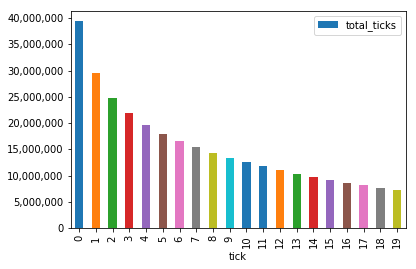

In [26]:
ax = mwsessiontick.plot(x='tick', y='total_ticks', kind='bar')
ax.yaxis.set_major_formatter(mpl('{x:,.0f}'))
plt.show()

Count of Tick 0s is greater than all other ticks in the raw table which is ideal.

## 5. Percentile Compare 
The session length metric allows us to calculate percentiles (% of sessions lasting up to some length, % of sessions lasting at least some length). It is important to check if the percentiles calculated from the raw table are similar to the percentiles calculated from the data in the intermediate table.
For this we will first calculate the differences in session lengths observed in the raw table and sessionized table. We will then build a histogram of the values to illustrate the differences and then calculate percentiles of sessions to compare the values between the two tables. 



#### 5.1 Compare session length for Jan 19, 2021

In [34]:
#For 2021, Month=1, day=19

histogram_query_0119 = """
with tick_histogram as (
    select
        tick,
        count(1) as freq
    from event.mediawiki_client_session_tick
    where
        year=2021 and
        month=1 and
        day=19
        AND is_wmf_domain
    group by tick
    order by tick asc
    limit 1000
),
session_histogram_from_raw as (
    select
        one.tick as session_length,
        one.freq - coalesce(two.freq, 0) as freq
    from tick_histogram as one
    left join tick_histogram as two
    on one.tick + 1 = two.tick
),
session_histogram_from_intermediate as (
    select
        session_length,
        count(1) as freq
    from mforns.session_length_daily
    where
        year=2021 and
        month=1 and
        day=19
    group by session_length
    order by session_length asc
    limit 1000
)
select
    coalesce(raw.session_length, itm.session_length) as session_length,
    coalesce(raw.freq, 0) as raw_freq,
    coalesce(itm.freq, 0) as itm_freq,
    coalesce(itm.freq, 0) - coalesce(raw.freq, 0) as offset
from session_histogram_from_raw as raw
full outer join session_histogram_from_intermediate as itm
    on raw.session_length = itm.session_length
;
"""


In [35]:
compare_hist_0119=hive.run(histogram_query_0119)

The table below provides difference between number of sessions of a certain length in the raw and intermediate table.  
Positive offset values indicate that number of sessions in the intermediate table is greater than raw table and negative offset indicates vice versa. 


In [36]:
compare_hist_0119.head()

,session_length,raw_freq,itm_freq,offset
0,0,682584,682582,-2
1,1,318181,318187,6
2,2,202436,202432,-4
3,3,148724,148725,1
4,4,118356,118344,-12


Text(0, 0.5, 'number_of_sessions')

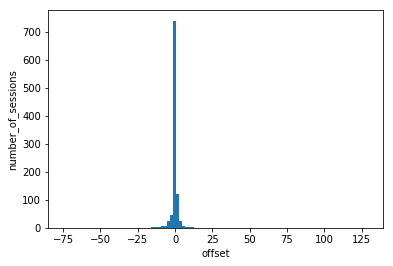

In [37]:
#plot the distribution
histogram_0119=plt.hist(compare_hist_0119['offset'], 100)
plt.xlabel('offset')
plt.ylabel('number_of_sessions')
                  

In [40]:
compare_hist0119_nonzero = compare_hist_0119[compare_hist_0119['offset'] !=0]
compare_hist0119_nonzero.shape

(363, 4)

The graph shows that most session lengths have equal number of sessions between the two tables. The few session lengths that are different have a small variation in the number of sessions.     


To calculate percentiles we will run a python script on the hive query for data from Jan 20, 2021, that will give us the proportion of sessions lasting at least some length from raw and intermediate tables. 

In [32]:
#Python Script for calculating and comparing percentile

import re
import sys
data = []
for line in sys.stdin:
    row = [int(v) for v in re.split(r'\t+', line)]
    data.append(row)
total_sessions_raw = sum([row[1] for row in data])
total_sessions_itm = sum([row[2] for row in data])
cumulative_sessions_raw = 0
cumulative_sessions_itm = 0
for row in data:
    cumulative_sessions_raw += row[1]
    cumulative_sessions_itm += row[2]
    decorated_row = row + [
        cumulative_sessions_raw / total_sessions_raw,
        cumulative_sessions_itm / total_sessions_itm
    ]
    print(*decorated_row)

In [ ]:
hive -f sl_daily_compare_percentile_0119.hql 2> /dev/null > sl_daily_compare_percentile_output_0119.tsv

In [ ]:
tail -n +2 sl_daily_compare_percentile_output_0119.tsv | python3 session_length_decorate_histograms.py | tee sl_daily_compare_percentile_output_0119.log

_Complete Output of the py script is provided in_ [sl_daily_compare_percentile_output_0119.log](https://github.com/wikimedia-research/Session-Length-Metric/blob/main/Data-QA/sl_daily_compare_percentile_output_0119.log)



#### 5.2 Compare session length for a wiki (example:Catalan wikipedia)

In [41]:
# Count frequency of Ticks from raw table 
# Count frequency of session lengths from intermediate table
# calculate a histogram of ticks and then do a self-join to do the subtraction 

#For wiki= cawiki
cawiki_histogram_queries = """
with tick_histogram as (
    select
        tick,
        count(1) as freq
    from event.mediawiki_client_session_tick
    where
        year=2021 and
        month=1 
        AND day>=6 AND day<22 
        AND is_wmf_domain and
        meta.domain IN ('ca.wikipedia.org', 'ca.m.wikipedia.org')
    group by tick
    order by tick asc
    limit 1000
),
session_histogram_from_raw as (
    select
        one.tick as session_length,
        one.freq - coalesce(two.freq, 0) as freq
    from tick_histogram as one
    left join tick_histogram as two
    on one.tick + 1 = two.tick
),
session_histogram_from_intermediate as (
    select
        session_length,
        count(1) as freq
    from mforns.session_length_daily
    where
        year=2021 AND day>=6 and
        wiki='ca.wikipedia'

    group by session_length
    order by session_length asc
    limit 1000
)
select
    coalesce(raw.session_length, itm.session_length) as session_length,
    coalesce(raw.freq, 0) as raw_freq,
    coalesce(itm.freq, 0) as itm_freq,
    coalesce(itm.freq, 0) - coalesce(raw.freq, 0) as offset
from session_histogram_from_raw as raw
full outer join session_histogram_from_intermediate as itm
    on raw.session_length = itm.session_length
;
"""


In [42]:
cawiki_compare_histogram=hive.run(cawiki_histogram_queries)

Text(0, 0.5, 'number_of_sessions')

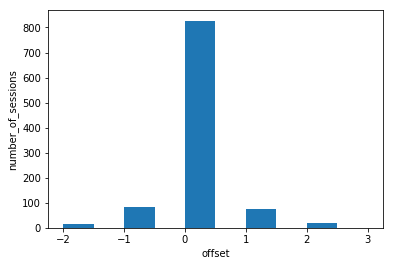

In [43]:
#plot the distribution of differences for cawiki
cawiki_histogram=plt.hist(cawiki_compare_histogram['offset'], 10)
plt.xlabel('offset')
plt.ylabel('number_of_sessions')
                  

Cawiki is closer to the UTC time zone and will not be greatly affected by the end of day capping of the sessionized table. Hence there isn't a huge difference in the sessions between the two tables.
Let's look at another wiki that is farther from UTC. 

#### 5.3 Compare session length for a wiki (example: English wiktionary)

In [44]:
# Count frequency of Ticks from raw table 
# Count frequency of session lengths from intermediate table
# calculate a histogram of ticks and then do a self-join to do the subtraction 

#For wiki= en.wiktionary
enwikt_histogram_queries = """
with tick_histogram as (
    select
        tick,
        count(1) as freq
    from event.mediawiki_client_session_tick
    where
        year=2021 and
        month=1 and
        day>=6 AND day<22 
        AND is_wmf_domain and
        meta.domain IN ('en.wiktionary.org', 'en.m.wiktionary.org')
    group by tick
    order by tick asc
    limit 1000
),
session_histogram_from_raw as (
    select
        one.tick as session_length,
        one.freq - coalesce(two.freq, 0) as freq
    from tick_histogram as one
    left join tick_histogram as two
    on one.tick + 1 = two.tick
),
session_histogram_from_intermediate as (
    select
        session_length,
        count(1) as freq
    from mforns.session_length_daily
    where
        year=2021 AND day>=6 and
        wiki='en.wiktionary'

    group by session_length
    order by session_length asc
    limit 1000
)
select
    coalesce(raw.session_length, itm.session_length) as session_length,
    coalesce(raw.freq, 0) as raw_freq,
    coalesce(itm.freq, 0) as itm_freq,
    coalesce(itm.freq, 0) - coalesce(raw.freq, 0) as offset
from session_histogram_from_raw as raw
full outer join session_histogram_from_intermediate as itm
    on raw.session_length = itm.session_length
;
"""


In [45]:
enwikt_compare_histogram=hive.run(enwikt_histogram_queries)

Text(0, 0.5, 'number_of_sessions')

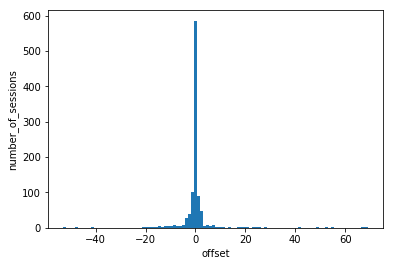

In [46]:
#plot the distribution of differences for cawiki
enwikt_compare_hist=plt.hist(enwikt_compare_histogram['offset'], 100)
plt.xlabel('offset')
plt.ylabel('number_of_sessions')

In [47]:
enwikt_not_0 = enwikt_compare_histogram[enwikt_compare_histogram['offset'] != 0]
enwikt_not_0.shape

(417, 4)

There are more number of sessions that are different between the two tables however their differences are below +/- 100 sessions. 

Let's calculate percentiles on all the data we have in the sessionized table and corresponding data from raw table (without date or wiki filters)

In [48]:
# Count frequency of Ticks from raw table 
# Count frequency of session lengths from intermediate table
# calculate a histogram of ticks and then do a self-join to do the subtraction 

#For all days and all wikis
histogram_queries = """
with tick_histogram as (
    select
        tick,
        count(1) as freq
    from event.mediawiki_client_session_tick
    where
        year=2021 and
        month=1 
        AND day>=6 and day<22 
        AND is_wmf_domain
    group by tick
    order by tick asc
    limit 1000
),
session_histogram_from_raw as (
    select
        one.tick as session_length,
        one.freq - coalesce(two.freq, 0) as freq
    from tick_histogram as one
    left join tick_histogram as two
    on one.tick + 1 = two.tick
),
session_histogram_from_intermediate as (
    select
        session_length,
        count(1) as freq
    from mforns.session_length_daily
    where
        year=2021 AND day>=6

    group by session_length
    order by session_length asc
    limit 1000
)
select
    coalesce(raw.session_length, itm.session_length) as session_length,
    coalesce(raw.freq, 0) as raw_freq,
    coalesce(itm.freq, 0) as itm_freq,
    coalesce(itm.freq, 0) - coalesce(raw.freq, 0) as offset
from session_histogram_from_raw as raw
full outer join session_histogram_from_intermediate as itm
    on raw.session_length = itm.session_length
;
"""


In [49]:
hist_compare=hive.run(histogram_queries)

Text(0, 0.5, 'number_of_sessions')

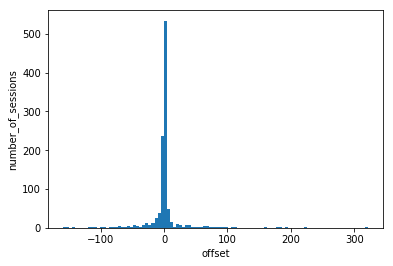

In [52]:
#plot the distribution of differences 
hist_compare_all=plt.hist(hist_compare['offset'], 100)
plt.xlabel('offset')
plt.ylabel('number_of_sessions')
                  

In [51]:
diff_not_0 = hist_compare[hist_compare['offset'] != 0]
diff_not_0.shape

(792, 4)

When we compare All of the data in the two tables, we see that very few session lengths that have the same number of sessions in the two tables ie majority of the session lengths are non-zero, which is concerning.      
Hence we will calculate the percentiles of the session lengths and compare the values. 

In [ ]:
hive -f sl_daily_compare_percentile.hql 2> /dev/null > sl_daily_compare_percentile_output.tsv

In [ ]:
tail -n +2 sl_daily_compare_percentile_output.tsv | python3 session_length_decorate_histograms.py | tee sl_daily_compare_percentile_output.log

_Complete Output of the py script is provided in_ [sl_daily_compare_percentile_output.log](https://github.com/wikimedia-research/Session-Length-Metric/blob/main/Data-QA/sl_daily_compare_percentile_output.log)


The Percentile values are almost the same between the two tables.   
**Conclusion** : Eventhough the overall duration of all sessions and count of sessions between the raw and intermediate table is slightly different we have verified that it has no impact to the session length metric (percentiles). 
